# Benchmarking DenseDepth #

In [121]:
import os
import sys
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

#### NYU Data Loader ####

NYU v2 dataset is available [here](https://drive.google.com/drive/folders/1TzwfNA5JRFTPO-kHMU___kILmOEodoBo).
Download and unzip to proceed with this notebook.

In [122]:
'''
Load NYU Dataset for evaluation.
    Args:
        path - path to nyu dataset test directory.
        count - how many images to load.
        return - a tuple of numpy arrays of rgb and corresponding depth images.
'''
def load_nyu_images(path: str, count=111) -> (np.array, np.array):

    # Collect image path
    rgb_img_path = []
    depth_img_path = []

    with os.scandir(path) as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():
                if "colors.png" in entry.name:
                    rgb_img_path.append(entry.name)
                elif "depth.png" in entry.name:
                    depth_img_path.append(entry.name)

    rgb_img_path = [path + "/" + name for name in sorted(rgb_img_path)]
    depth_img_path = [path + "/" + name for name in sorted(depth_img_path)]

    rgb_img = [np.clip(np.asarray(Image.open(path), dtype=float) / 255, 0, 1) for path in rgb_img_path[:count]]
    depth_img = [np.asarray(Image.open(path), dtype=float) for path in depth_img_path[:count]]
    depth_img = [1000 / np.clip(1000 * img / np.max(img), 10, 1000) for img in depth_img]

    return np.stack(rgb_img), np.stack(depth_img)

#### Load Model ####

1. Get pretrained DeepDense model (~200MB) from [here](https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5).
2. Clone [DeepDense](https://github.com/ialhashim/DenseDepth) repository. This is required to load custom
layers which are not part of tensorflow. We would only need the `layers.py` file from the repository.

In [123]:
# Path to the directory containing `layers.py`
sys.path.append("/Users/slava/projects/DenseDepth")
from layers import BilinearUpSampling2D

# Custom object needed for model inference..
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
model = tf.keras.models.load_model("/Users/slava/Downloads/nyu.h5",
                                   custom_objects=custom_objects,
                                   compile=False)

#### Predict NYU Depth ####
Run loaded NYU test images through the model to get predicted depth.

In [124]:
# Load Images
nyu_rgb, nyu_depth = load_nyu_images("/Users/slava/Downloads/nyu_data/data/nyu2_test")

# Predict Depth
prediction_depth = model.predict(nyu_rgb)


#### Visualize Prediction ####

Pick a random triple of images from the batch.

In [125]:
random_index = random.randrange(prediction_depth.shape[0])

Prediction Without Normalization


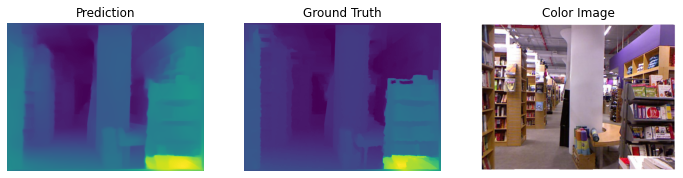

In [126]:
f, axarr = plt.subplots(ncols=3, figsize=(12, 8))

for ax in axarr:
    ax.axis("off")

print("Prediction Without Normalization")
axarr[0].set_title("Prediction")
axarr[0].imshow(prediction_depth[random_index, :, :, 0])

axarr[1].set_title("Ground Truth")
axarr[1].imshow(10 * nyu_depth[random_index, :, :])

axarr[2].set_title("Color Image")
axarr[2].imshow(nyu_rgb[random_index, :, :])

plt.show()

#### Normalize Prediction and Ground Truth ####

Apply Z score normalization to both predictions and truth.
Normalization is required to further compare errors among different datasets.

Visualize to check if the result is still valid -- should not visually differ much from non-normalized.

-1.4623006e-07 -1.2138438402568377e-16
Prediction Normalized


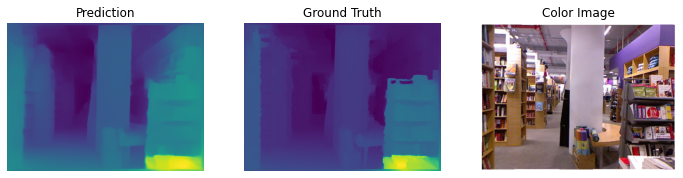

In [127]:
f, axarr = plt.subplots(ncols=3, figsize=(12, 8))

for ax in axarr:
    ax.axis("off")

prediction_norm = (prediction_depth[random_index, :, :, 0] - np.mean(prediction_depth[random_index, :, :, 0])) / np.std(prediction_depth[random_index, :, :, 0])
truth_norm = (nyu_depth[random_index, :, :] - np.mean(nyu_depth[random_index, :, :])) / np.std(nyu_depth[random_index, :, :])

print(np.mean(prediction_norm), np.mean(truth_norm))
print("Prediction Normalized")
axarr[0].set_title("Prediction")
axarr[0].imshow(prediction_norm)

axarr[1].set_title("Ground Truth")
axarr[1].imshow(truth_norm)

axarr[2].set_title("Color Image")
axarr[2].imshow(nyu_rgb[random_index, :, :])
